# Part VI: Tuning XGBoost Classifier
In the previous notebook, the xgboost classifier returned the highest roc_auc score with default parameters. This notebook will investigate if the model can return an even higher score after hyperparameter tuning. Tuning is achieved by figuring out the number of trees in the classifier then tuning each parameter within the model using the hyperopt library.  

In [108]:
import pandas as pd
import numpy as np
#Min-Max Scaled dataframe
w_inactive_auc_bid_behavior_df=pd.read_csv('datasets/w_inactive_auc_bid_behavior_df.csv')
train=pd.read_csv('datasets/train.csv')
test=pd.read_csv('datasets/test.csv')

In [109]:
train_ids=train['bidder_id']
test_ids=test['bidder_id']
#split into train and unknown features / assign y as outcome drop outcome for X
feats_train=train[['bidder_id','outcome']].merge(w_inactive_auc_bid_behavior_df)

Y=feats_train['outcome']
X=feats_train.drop(columns=['outcome']).iloc[:,1:]
train_ids=train['bidder_id']
#unknown features
unk_features=w_inactive_auc_bid_behavior_df[w_inactive_auc_bid_behavior_df.bidder_id.isin(test['bidder_id'])].iloc[:,1:]
unk_ids=w_inactive_auc_bid_behavior_df[w_inactive_auc_bid_behavior_df.bidder_id.isin(test['bidder_id'])]['bidder_id']

In [110]:
import pandas as pd
import re
import gc
import numpy as np
from scipy import sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.externals import joblib
import xgboost as xgb
from sklearn.model_selection import cross_val_predict
import sklearn 
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# select top 25% of features
feats_25 = SelectPercentile(chi2, 25).fit(X, Y)
X = feats_25.transform(X)
unk_features = feats_25.transform(unk_features)

In [111]:
# i used this guide to tune xgboost parameters
# https://www.kaggle.com/eikedehling/tune-and-compare-xgb-lightgbm-rf-with-hyperopt
# step 1: determine the best number of trees with high learning rate and n_estimators
xgtrain = xgb.DMatrix(X, label=Y)
clf = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb_param = clf.get_xgb_params()

cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['auc'],
     early_stopping_rounds=50, stratified=True, seed=1301,verbose_eval=True)
print('Best number of trees = {}'.format(cvresult.shape[0]))

[0]	train-auc:0.862915+0.0433512	test-auc:0.769572+0.0660209
[1]	train-auc:0.937885+0.02178	test-auc:0.841271+0.0738714
[2]	train-auc:0.961601+0.0159809	test-auc:0.866615+0.0466036
[3]	train-auc:0.96894+0.0155877	test-auc:0.867981+0.0404331
[4]	train-auc:0.975616+0.00628569	test-auc:0.870472+0.0392912
[5]	train-auc:0.981555+0.00605913	test-auc:0.868538+0.0378375
[6]	train-auc:0.983133+0.00812396	test-auc:0.87533+0.0370239
[7]	train-auc:0.988322+0.00394927	test-auc:0.878356+0.0363413
[8]	train-auc:0.989205+0.00375775	test-auc:0.890234+0.0362829
[9]	train-auc:0.991944+0.00229152	test-auc:0.895151+0.0422874
[10]	train-auc:0.992455+0.00252784	test-auc:0.894536+0.0425279
[11]	train-auc:0.993104+0.00220206	test-auc:0.894907+0.0411046
[12]	train-auc:0.993682+0.00215085	test-auc:0.895958+0.0418732
[13]	train-auc:0.994154+0.00204309	test-auc:0.898472+0.0442506
[14]	train-auc:0.994094+0.00213603	test-auc:0.899354+0.042717
[15]	train-auc:0.994251+0.00200982	test-auc:0.900613+0.0419867
[16]	train-

In [112]:
#determine other parameters after figuring optimal trees/n_estinators 
import numpy as np
import pandas as pd

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_child_weight': int(params['min_child_weight']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': params['subsample']
    }
    
    clf = xgb.XGBClassifier(
        n_estimators=54,
        learning_rate=0.1,
        #n_jobs=4,
        **params
    )
    
    score = cross_val_score(clf, X, Y, scoring='roc_auc', cv=StratifiedKFold(),n_jobs=-1).mean()
    print("roc_auc {:.3f} params {}".format(score, params))
    return score

space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'subsample': hp.uniform('subsample', 0.3, 1.0)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=500)

roc_auc 0.927 params {'gamma': '0.021', 'colsample_bytree': '0.897', 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.9752131711392364}
roc_auc 0.926 params {'gamma': '0.447', 'colsample_bytree': '0.680', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.8269725383937769}
roc_auc 0.928 params {'gamma': '0.029', 'colsample_bytree': '0.591', 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.893321581271884}
roc_auc 0.929 params {'gamma': '0.114', 'colsample_bytree': '0.405', 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8567766311185196}
roc_auc 0.923 params {'gamma': '0.231', 'colsample_bytree': '0.921', 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.41208706194742944}
roc_auc 0.931 params {'gamma': '0.015', 'colsample_bytree': '0.371', 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.7939908417450701}
roc_auc 0.929 params {'gamma': '0.384', 'colsample_bytree': '0.693', 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.6668013706411042}
roc_auc 0.930

roc_auc 0.916 params {'gamma': '0.073', 'colsample_bytree': '0.807', 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5339435064455503}
roc_auc 0.916 params {'gamma': '0.131', 'colsample_bytree': '0.978', 'max_depth': 2, 'min_child_weight': 3, 'subsample': 0.3259723490256085}
roc_auc 0.920 params {'gamma': '0.048', 'colsample_bytree': '0.668', 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.39776909911088415}
roc_auc 0.929 params {'gamma': '0.166', 'colsample_bytree': '0.844', 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8983267644847768}
roc_auc 0.918 params {'gamma': '0.420', 'colsample_bytree': '0.541', 'max_depth': 2, 'min_child_weight': 4, 'subsample': 0.4306544624496479}
roc_auc 0.927 params {'gamma': '0.018', 'colsample_bytree': '0.344', 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.47648482949588866}
roc_auc 0.913 params {'gamma': '0.106', 'colsample_bytree': '0.779', 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.34645657754658726}
roc_auc 0.

roc_auc 0.933 params {'gamma': '0.081', 'colsample_bytree': '0.706', 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7823949211757051}
roc_auc 0.909 params {'gamma': '0.115', 'colsample_bytree': '0.636', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.37077395313401207}
roc_auc 0.923 params {'gamma': '0.008', 'colsample_bytree': '0.539', 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.735263174846437}
roc_auc 0.914 params {'gamma': '0.048', 'colsample_bytree': '0.579', 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.3495051016081331}
roc_auc 0.923 params {'gamma': '0.087', 'colsample_bytree': '0.616', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.63104502413015}
roc_auc 0.914 params {'gamma': '0.126', 'colsample_bytree': '0.443', 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.33415002579709796}
roc_auc 0.932 params {'gamma': '0.103', 'colsample_bytree': '0.676', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.9109069609391507}
roc_auc 0.916 

roc_auc 0.917 params {'gamma': '0.125', 'colsample_bytree': '0.837', 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.35040450106972926}
roc_auc 0.917 params {'gamma': '0.163', 'colsample_bytree': '0.960', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.3850858598168135}
roc_auc 0.928 params {'gamma': '0.011', 'colsample_bytree': '0.764', 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8640237075517717}
roc_auc 0.914 params {'gamma': '0.451', 'colsample_bytree': '0.632', 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.3205661056814807}
roc_auc 0.916 params {'gamma': '0.071', 'colsample_bytree': '0.917', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.36687256611162855}
roc_auc 0.922 params {'gamma': '0.222', 'colsample_bytree': '0.554', 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.48748466223301046}
roc_auc 0.925 params {'gamma': '0.097', 'colsample_bytree': '0.669', 'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.6067255516906723}
roc_auc 0.

roc_auc 0.917 params {'gamma': '0.073', 'colsample_bytree': '0.837', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.5008688939137733}
roc_auc 0.932 params {'gamma': '0.024', 'colsample_bytree': '0.715', 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9105130604196408}
roc_auc 0.918 params {'gamma': '0.115', 'colsample_bytree': '0.746', 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.3566781671855807}
roc_auc 0.926 params {'gamma': '0.203', 'colsample_bytree': '0.441', 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.946558414059959}
roc_auc 0.925 params {'gamma': '0.147', 'colsample_bytree': '0.682', 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.5235252569662947}
roc_auc 0.907 params {'gamma': '0.043', 'colsample_bytree': '0.763', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.3197337863106966}
roc_auc 0.912 params {'gamma': '0.342', 'colsample_bytree': '0.810', 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.3098998556377663}
roc_auc 0.916 

roc_auc 0.913 params {'gamma': '0.054', 'colsample_bytree': '0.658', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.31164512768732866}
roc_auc 0.906 params {'gamma': '0.011', 'colsample_bytree': '0.685', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3322712425604061}
roc_auc 0.924 params {'gamma': '0.127', 'colsample_bytree': '0.580', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.8253878159463156}
roc_auc 0.913 params {'gamma': '0.098', 'colsample_bytree': '0.558', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.37295513482819387}
roc_auc 0.920 params {'gamma': '0.062', 'colsample_bytree': '0.959', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3540826133508282}
roc_auc 0.919 params {'gamma': '0.045', 'colsample_bytree': '0.490', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.6529897317856972}
roc_auc 0.910 params {'gamma': '0.087', 'colsample_bytree': '0.642', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.39675675665338717}
roc_auc 0.

roc_auc 0.918 params {'gamma': '0.026', 'colsample_bytree': '0.952', 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.3137716614029325}
roc_auc 0.921 params {'gamma': '0.117', 'colsample_bytree': '0.747', 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5953632176678954}
roc_auc 0.913 params {'gamma': '0.038', 'colsample_bytree': '0.615', 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.39732372371253644}
roc_auc 0.918 params {'gamma': '0.083', 'colsample_bytree': '0.925', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.3636965296487051}
roc_auc 0.904 params {'gamma': '0.014', 'colsample_bytree': '0.731', 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.32930768324599136}
roc_auc 0.919 params {'gamma': '0.021', 'colsample_bytree': '0.710', 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.5130364863828144}
roc_auc 0.924 params {'gamma': '0.000', 'colsample_bytree': '0.657', 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9884320575530456}
roc_auc 0.9

roc_auc 0.914 params {'gamma': '0.065', 'colsample_bytree': '0.840', 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.3951707030381318}
roc_auc 0.916 params {'gamma': '0.049', 'colsample_bytree': '0.889', 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.3358502622568484}
roc_auc 0.912 params {'gamma': '0.111', 'colsample_bytree': '0.749', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.36541467557203056}
roc_auc 0.908 params {'gamma': '0.086', 'colsample_bytree': '0.726', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3817850149648038}
roc_auc 0.910 params {'gamma': '0.000', 'colsample_bytree': '0.794', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.315354958138133}
roc_auc 0.912 params {'gamma': '0.021', 'colsample_bytree': '0.905', 'max_depth': 2, 'min_child_weight': 5, 'subsample': 0.34090307384891577}
roc_auc 0.909 params {'gamma': '0.058', 'colsample_bytree': '0.689', 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.3011272984469591}
roc_auc 0.91

roc_auc 0.911 params {'gamma': '0.011', 'colsample_bytree': '0.797', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.3712260158408602}
roc_auc 0.921 params {'gamma': '0.048', 'colsample_bytree': '0.952', 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.31788147297340713}
roc_auc 0.915 params {'gamma': '0.097', 'colsample_bytree': '0.863', 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.38966463562839826}
roc_auc 0.913 params {'gamma': '0.000', 'colsample_bytree': '0.644', 'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.3531905445371348}
roc_auc 0.931 params {'gamma': '0.058', 'colsample_bytree': '0.706', 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9289333468642444}
roc_auc 0.911 params {'gamma': '0.139', 'colsample_bytree': '0.619', 'max_depth': 2, 'min_child_weight': 6, 'subsample': 0.3363125414098927}
roc_auc 0.919 params {'gamma': '0.256', 'colsample_bytree': '0.355', 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.46812119937956537}
roc_auc 0.

In [113]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'subsample': 0.33068423799015884, 'colsample_bytree': 0.7025553950920269, 'max_depth': 5.0, 'gamma': 0.09046294757537861, 'min_child_weight': 6.0}


0.636523642144
             precision    recall  f1-score   support

        0.0       0.96      0.99      0.98      1881
        1.0       0.64      0.28      0.39       103

avg / total       0.95      0.95      0.95      1984



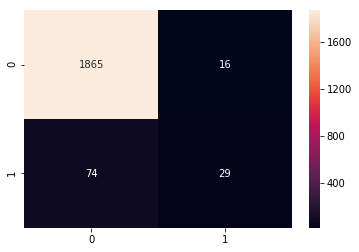

In [115]:
xtrain=X
xtest=unk_features
#feature selection
feats_25 = SelectPercentile(chi2, 25).fit(xtrain, Y)
xtrain = feats_25.transform(xtrain)
xtest = feats_25.transform(xtest)

clf = xgb.XGBClassifier(objective = 'binary:logistic',
                            learning_rate = 0.1,
                            max_depth = 5,
                            seed = 42,
                            colsample_bytree = 0.7025553950920269,
                            subsample=0.33068423799015884,
                            min_child_weight = 6,
                            n_estimators = 68,
                            gamma = 0.09046294757537861, silent = True)
model=clf
model.fit(X,Y)
#print pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)[:15]

y_pred = cross_val_predict(model,X,Y,cv=10)
from sklearn.metrics import roc_auc_score
print roc_auc_score(Y, y_pred)

# Classif report and conf mat
print sklearn.metrics.classification_report(Y, y_pred)
sns.heatmap(confusion_matrix(Y,y_pred),annot=True,fmt='2.0f')
plt.show()

In [117]:
#bag of 15 models
rounds = 15
preds_mat = np.zeros((len(unk_ids.index), rounds))
for i in range(rounds):
    clf.set_params(seed = i + 1)
    clf.fit(xtrain, Y)
    preds_tmp = clf.predict_proba(xtest)[:, 1]
    preds_mat[:, i] = preds_tmp
bagged_preds = preds_mat.mean(axis = 1)
xboost_preds=pd.DataFrame({'bidder_id':unk_ids,'prediction':bagged_preds})
xboost_preds.to_csv('submissions/submission1.csv', index = False)

# Results
When uploaded to Kaggle, the model scores a 92% in accuracy. I also uploaded other xgboost models that had a higher roc_auc score but when uploaded, did not do as well on the leaderboards. My ultimate takeaway from this project was learning how to generate meaningful features from log data that were robust enough to capture behavior in the unknown group without overfitting the training data. I also learned how to tune xgboost using the hyperopt library. If I were to improve on this project, I would look more into generating features on the url and ip addresses in the bidding log as these may have generated more insight into single bidding users.